In [3]:
%load_ext autoreload
%autoreload 1


In [4]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score, median_absolute_error
import warnings

from computage.utils.data_utils import download_meta, download_dataset
from computage.utils.nan_utils import EN_nan_row_predict,introduce_nans

from computage.models_library.model import LinearMethylationModel

import pandas as pd
import gzip

# loading + preprocessing

In [5]:
# data = pd.read_csv('full_blood_HC.csv')
# data
import os
import glob

#import reader
from multiprocessing import Pool

def read_psv_all (file_name):
    return pd.read_csv(file_name,
                       #delimiter='',  # change this as needed                              
                       low_memory=False, index_col = ['Unnamed: 0']
                      ) 

pool = Pool(processes=3) # can change 3 to number of processors you want to utilize
data = read_psv_all('full_blood_HC.csv')
data.head()

,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,cg24335620,cg16162899,...,cg27356438,cg27409364,cg27425675,cg27443050,cg27460755,cg27476329,cg27513764,cg27530424,cg27585441,cg27657249
GSM1443658,0.850345,0.571662,0.115101,0.217371,0.136810,0.699549,0.747217,0.107723,0.766730,0.813303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443800,0.821636,0.506415,0.138980,0.212379,0.090243,0.586473,0.747264,0.233739,0.792255,0.808847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443272,0.802247,0.518845,0.151033,0.288431,0.107367,0.618184,0.795986,0.129477,0.735356,0.828617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443250,0.851498,0.601998,0.104490,0.188970,0.107187,0.731727,0.749568,0.221319,0.778124,0.832554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443266,0.824495,0.608025,0.108236,0.192101,0.097375,0.556048,0.714904,0.249572,0.767942,0.806314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.shape

(1079, 487177)

In [7]:
meta = pd.read_csv('full_blood_HC_meta.csv',index_col = ['Unnamed: 0'])
meta.shape

(1079, 59)

In [8]:
meta

,Unnamed: 0.1,Title,Tissue,CellType,Gender,Age,Condition,_ConditionSubtype,Platform,SourceGSE,...,_DNAmAge,Condition_SmokingStatus,Ethnicity,_BrodmannArea,_H_in,_W_lb,_ConditionAnemia,_SmokingStatus,_AlcoholStatus,_TcellsES
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
GSM1443250,0,NaN,Blood,Whole blood,F,79.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443266,1,NaN,Blood,Whole blood,F,90.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443272,2,NaN,Blood,Whole blood,M,78.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443658,3,NaN,Blood,Whole blood,F,84.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443796,4,NaN,Blood,Whole blood,M,76.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1354388,334,101247,Blood,CD14+,NaN,52.0,HC,NaN,GPL13534,GSE56046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011649
GSM1354392,335,101251,Blood,CD14+,NaN,45.0,HC,NaN,GPL13534,GSE56046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025156
GSM1354399,336,101258,Blood,CD14+,NaN,55.0,HC,NaN,GPL13534,GSE56046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000217


In [9]:
y = pd.DataFrame(meta['Age'])
y = y.rename(columns={'Age': 'age'})
y

,age
Unnamed: 0,
GSM1443250,79.0
GSM1443266,90.0
GSM1443272,78.0
GSM1443658,84.0
GSM1443796,76.0
...,...
GSM1354388,52.0
GSM1354392,45.0
GSM1354399,55.0


In [10]:
y.isna().sum()

age    1
dtype: int64

In [11]:
y[y['age'].isnull()].index.tolist()

['GSM796696']

In [12]:
data.loc['GSM796696']

cg13869341    0.85448
cg14008030    0.50837
cg12045430    0.07106
cg20826792    0.14338
cg00381604    0.05724
               ...   
cg27476329        NaN
cg27513764        NaN
cg27530424        NaN
cg27585441        NaN
cg27657249        NaN
Name: GSM796696, Length: 487177, dtype: float64

In [13]:

data = data.drop(y[y['age'].isnull()].index.tolist())
y = y.dropna()

In [14]:
meta[meta['Condition']!='HC']
# в этом датасете все здоровые

,Unnamed: 0.1,Title,Tissue,CellType,Gender,Age,Condition,_ConditionSubtype,Platform,SourceGSE,...,_DNAmAge,Condition_SmokingStatus,Ethnicity,_BrodmannArea,_H_in,_W_lb,_ConditionAnemia,_SmokingStatus,_AlcoholStatus,_TcellsES
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,


In [15]:
nan_pct = np.linspace(0, 0.9, 19)
def medae_r2(X,y,model):
    #nan_pct = [0.1]
    X_test = X.reindex(columns=model.features)
    y_test = y

    mae_uie = []
    r2_uie = []

    for p in nan_pct:
        X_nan = introduce_nans(X_test, p)
        #X_nan = X_nas
        y_pred_test = model.predict(X_nan)
        
        
        
        mae_uie.append(median_absolute_error(y_test, y_pred_test))
        r2_uie.append(r2_score(y_test, y_pred_test))
    return mae_uie, r2_uie    

In [16]:
mname="PhenoAge2018"
model_1 = LinearMethylationModel(name=mname)
modelX_w = data.reindex(columns=model_1.features)
percent_missing = modelX_w.isnull().sum().sum() / (modelX_w.shape[0]*modelX_w.shape[1])
print(f'already missed{round(percent_missing,2)}')

mae_0, r2_0 = medae_r2(data, y, model_1)
mae_avg, r2_avg = medae_r2(data, y, LinearMethylationModel(name=mname, imputation='average'))
mae_ses, r2_ses = medae_r2(data, y, LinearMethylationModel(name=mname, imputation="sesame_450k"))
#'sesame_450k'

already missed0.0


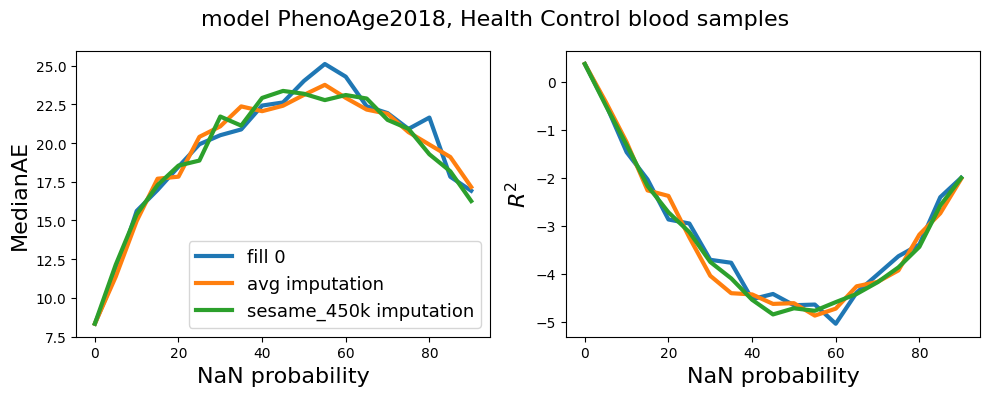

<Figure size 640x480 with 0 Axes>

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f'model {mname}, Health Control blood samples', fontsize=16)
ax[0].plot(nan_pct*100, mae_0, lw=3, label='fill 0')
ax[0].plot(nan_pct*100, mae_avg, lw =3, label = 'avg imputation')
ax[0].plot(nan_pct*100, mae_ses, lw =3, label = 'sesame_450k imputation')
ax[1].plot(nan_pct*100, r2_0, lw=3)
ax[1].plot(nan_pct*100, r2_avg, lw = 3)
ax[1].plot(nan_pct*100, r2_ses, lw = 3)


ax[0].set_xlabel('NaN probability', fontsize=16)
ax[1].set_xlabel('NaN probability', fontsize=16)
ax[0].set_ylabel('MedianAE', fontsize=16)
ax[1].set_ylabel('$R^2$', fontsize=16)
ax[0].legend(fontsize=13)
#ax[1].set_ylim([-0.5, 1.0])
plt.tight_layout()
plt.show()
plt.savefig(f'figures/{mname}.png')